In [5]:
import tensorflow as tf 
#!pip install gpflow --user
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']
get_available_gpus()
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 17744922279031770015, name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 3555563283437488606
 physical_device_desc: "device: XLA_GPU device", name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 4732010525113338769
 physical_device_desc: "device: XLA_CPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11281553818
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 14374998381043931112
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: d662:00:00.0, compute capability: 3.7"]

In [28]:
import numpy as np
import gpflow

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

matplotlib.rcParams['figure.figsize'] = (8, 4)
print(tf.__version__)

1.12.0


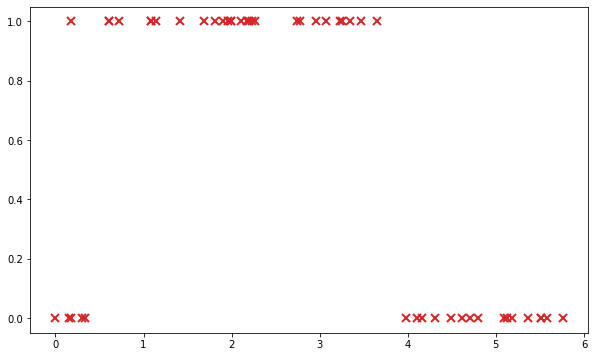

In [29]:
X = np.genfromtxt('data/classif_1D_X.csv').reshape(-1, 1)
Y = np.genfromtxt('data/classif_1D_Y.csv').reshape(-1, 1)

plt.figure(figsize=(10, 6))
plt.plot(X, Y, 'C3x', ms=8, mew=2);

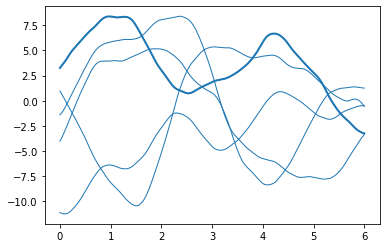

In [30]:
# build the kernel and covariance matrix
k = gpflow.kernels.Matern52(input_dim=1, variance=20.)
x_grid = np.linspace(0, 6, 200).reshape(-1, 1)
K = k.compute_K_symm(x_grid)

# sample from a multivariate normal
L = np.linalg.cholesky(K)
f_grid = np.dot(L, np.random.RandomState(6).randn(200, 5))
plt.plot(x_grid, f_grid, 'C0', linewidth=1)
plt.plot(x_grid, f_grid[:, 1], 'C0', linewidth=2);

In [37]:
import gpflow
import numpy as np
with gpflow.defer_build():
    X = np.random.rand(20, 1)
    Y = np.sin(12 * X) + 0.66 * np.cos(25 * X) + np.random.randn(20,1) * 0.01
    m = gpflow.models.GPR(X, Y, kern=gpflow.kernels.Matern32(1) + gpflow.kernels.Linear(1))
m.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
GPR/kern/kernels/0/lengthscales,Parameter,None,+ve,True,(),True,1.0
GPR/kern/kernels/0/variance,Parameter,None,+ve,True,(),True,1.0
GPR/kern/kernels/1/variance,Parameter,None,+ve,True,(),True,1.0
GPR/likelihood/variance,Parameter,None,+ve,True,(),True,1.0


In [38]:
m.kern.matern32.lengthscales = 0.5
m.likelihood.variance = 0.01
m.as_pandas_table()

AttributeError: 'Sum' object has no attribute 'matern32'

In [39]:
m.kern.matern32.variance.prior = gpflow.priors.Gamma(2,3)
m.as_pandas_table()

AttributeError: 'Sum' object has no attribute 'matern32'

In [4]:
from theano import function, config, shared, tensor
import numpy
import time

vlen = 10 * 30 * 768  # 10 x #cores x # threads per core
iters = 1000

rng = numpy.random.RandomState(22)
x = shared(numpy.asarray(rng.rand(vlen), config.floatX))
f = function([], tensor.exp(x))
print(f.maker.fgraph.toposort())
t0 = time.time()
for i in range(iters):
    r = f()
t1 = time.time()
print("Looping %d times took %f seconds" % (iters, t1 - t0))
print("Result is %s" % (r,))
if numpy.any([isinstance(x.op, tensor.Elemwise) and
              ('Gpu' not in type(x.op).__name__)
              for x in f.maker.fgraph.toposort()]):
    print('Used the cpu')
else:
    print('Used the gpu')

[Elemwise{exp,no_inplace}(<TensorType(float64, vector)>)]
Looping 1000 times took 4.059264 seconds
Result is [1.23178032 1.61879341 1.52278065 ... 2.20771815 2.29967753 1.62323285]
Used the cpu
